Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [421]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "potential_central_midfielder"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 
                      'StandingTackle', 'SlidingTackle',  'GKPositioning', 'GKReflexes','GKDiving', 'GKHandling', 'GKKicking']


PLAYER_ATTRIBUTES = [   'Finishing',  'ShortPassing',  'Dribbling', 'FKAccuracy', 'LongPassing','Composure', 
                       'Stamina', 'Strength', 'LongShots', 'Interceptions', 'Positioning', 'Vision', 'StandingTackle',]




In [422]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves
import config as CONFIG

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [423]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [424]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,age_based_Reactions,age_based_Dribbling,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,17.502664,31.843694,-3.713144,29.699822,2.902309,31.346359,27.808171,36.721137,27.376554,33.410894
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,13.717460,28.879365,9.719048,32.160635,11.850794,28.977778,15.171429,34.958730,26.241270,33.225397
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,12.830986,20.380282,8.190781,16.056082,9.382843,16.982074,15.554417,20.797695,15.592830,15.660265
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,14.938728,19.894798,2.326590,19.198382,9.764162,23.989595,23.932948,24.187283,20.012717,22.174181
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,14.938728,19.894798,0.326590,20.598382,16.764162,26.989595,12.932948,26.187283,14.012717,26.840848


# 

In [425]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [426]:
df = df[(df.central == 1)&(df.offense == 0)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
75.0    24
73.0    24
79.0    23
77.0    22
76.0    22
84.0    18
80.0    16
78.0    16
72.0    16
74.0    13
69.0     9
82.0     9
81.0     9
71.0     8
67.0     6
86.0     5
63.0     5
83.0     5
70.0     4
68.0     3
66.0     3
64.0     2
89.0     2
88.0     2
87.0     2
85.0     2
65.0     2
60.0     1
61.0     1
Name: count, dtype: int64


In [427]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
230767,Renato Sanches,2017,18.0,18.0,23.0,90.0,90.0,78.0,80.0,80.0,train,CM
230658,Arthur,2019,21.0,21.0,22.0,90.0,90.0,82.0,84.0,84.0,train,CM
252371,J. Bellingham,2022,18.0,18.0,20.0,89.0,89.0,79.0,86.0,86.0,valid,CM
235569,T. Ndombele,2020,22.0,22.0,24.0,89.0,89.0,81.0,82.0,82.0,test,CM
248243,E. Camavinga,2021,17.0,17.0,20.0,88.0,88.0,76.0,82.0,82.0,test,CM


In [428]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [429]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Composure', 'Defensive awareness', 'mental'], dtype='object')

#### Transform Value

In [430]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

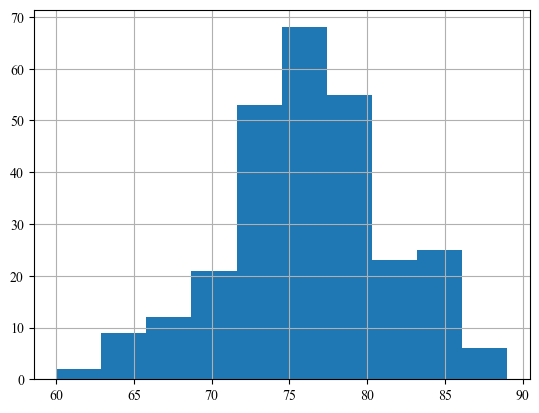

In [431]:
df['target'].hist()

In [432]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [433]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'Composure',
       'Defensive awareness', 'max_potential', 'prime_age', 'PrimeOverall',
       'best_position', 'central', 'winger', 'offense', 'Defense',
       'overall_age_ratio', 'youth_player', 'shooting', 'shooting_technique',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Strength',
       'age_based_React

In [434]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [435]:
y_train.describe()

count    152.000000
mean      77.105263
std        5.362561
min       63.000000
25%       74.000000
50%       77.000000
75%       81.000000
max       89.000000
Name: target, dtype: float64

In [436]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [437]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [438]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [439]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


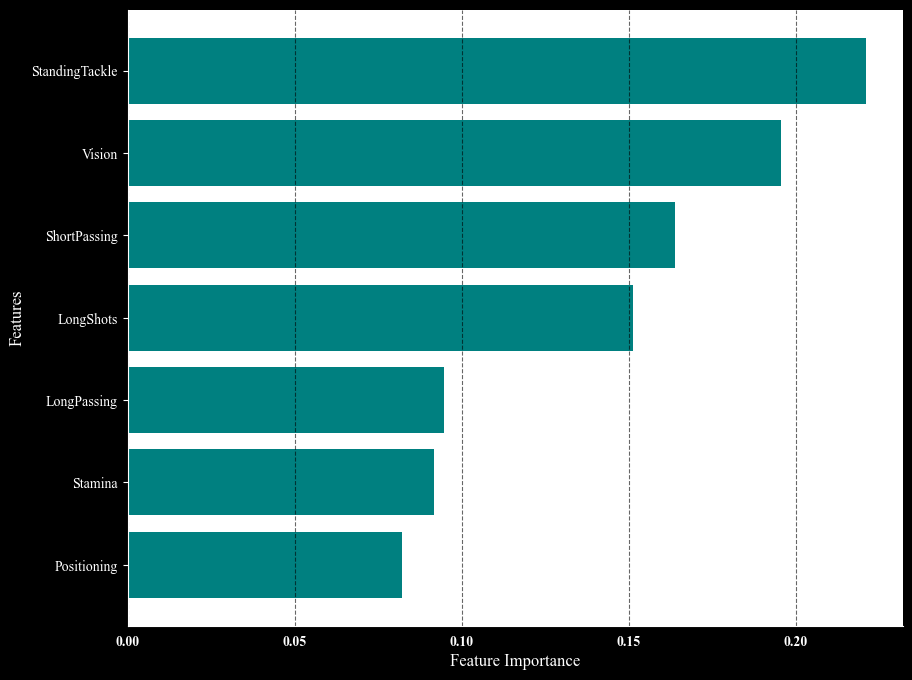

100%|██████████| 30/30 [00:01<00:00, 24.82it/s]


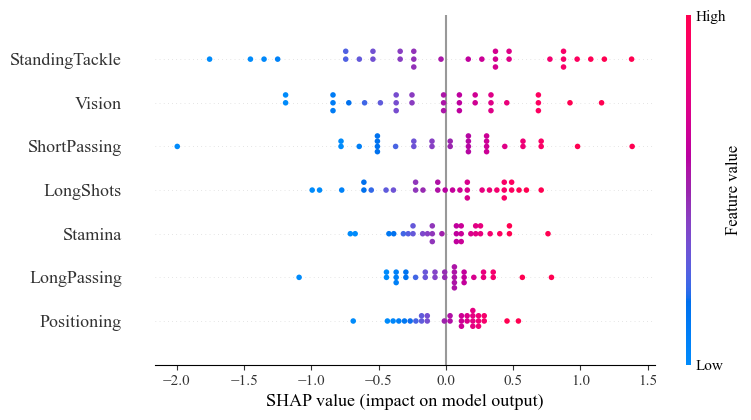

              precision    recall  f1-score   support

       False       0.95      0.90      0.93        42
        True       0.43      0.60      0.50         5

    accuracy                           0.87        47
   macro avg       0.69      0.75      0.71        47
weighted avg       0.89      0.87      0.88        47

Huber Regression training----->


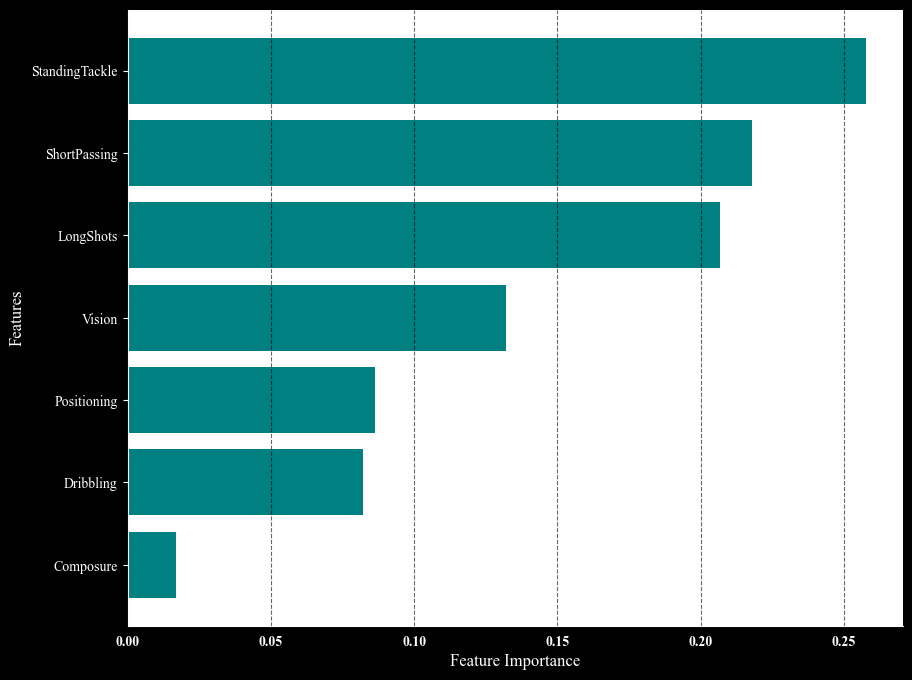

100%|██████████| 30/30 [00:01<00:00, 16.34it/s]


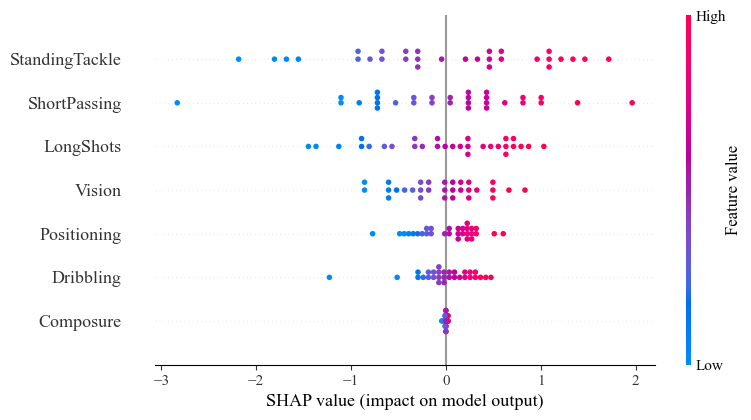

              precision    recall  f1-score   support

       False       0.95      0.93      0.94        42
        True       0.50      0.60      0.55         5

    accuracy                           0.89        47
   macro avg       0.73      0.76      0.74        47
weighted avg       0.90      0.89      0.90        47

Linear Regression training----->


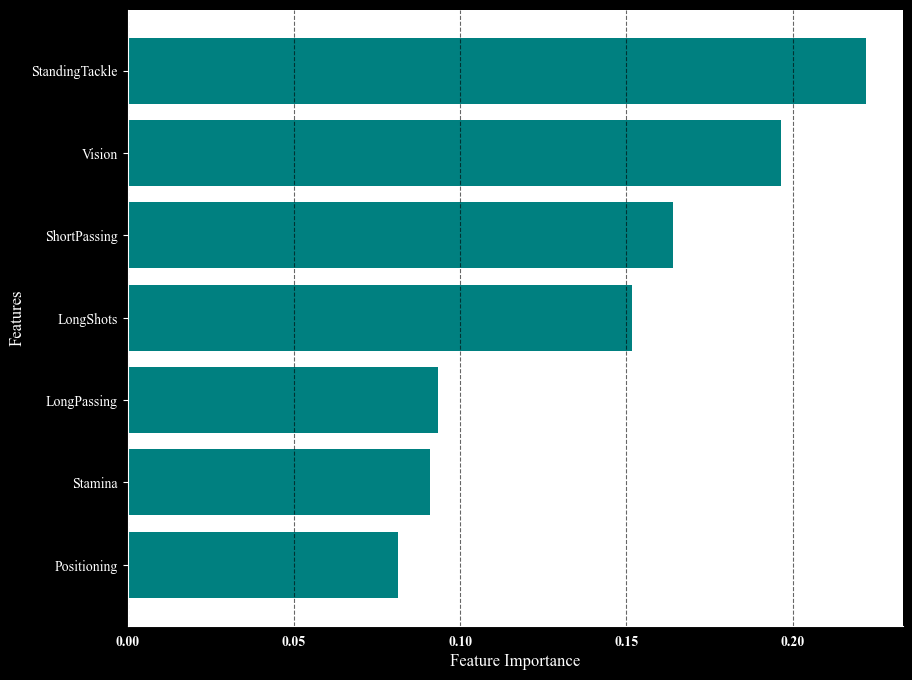

100%|██████████| 30/30 [00:01<00:00, 15.97it/s]


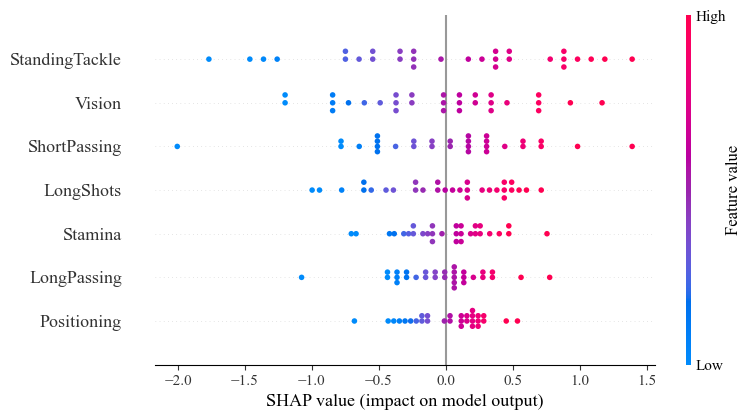

              precision    recall  f1-score   support

       False       0.95      0.90      0.93        42
        True       0.43      0.60      0.50         5

    accuracy                           0.87        47
   macro avg       0.69      0.75      0.71        47
weighted avg       0.89      0.87      0.88        47

Model: Ridge Regression
Mean Squared Error: 18.93
Mean Absolute Error: 3.69
R2 Score: 0.21

Model: Huber Regression
Mean Squared Error: 17.71
Mean Absolute Error: 3.56
R2 Score: 0.26

Model: Linear Regression
Mean Squared Error: 18.92
Mean Absolute Error: 3.69
R2 Score: 0.21



In [440]:
from sklearn.linear_model import LinearRegression,HuberRegressor

from src.sport_analytics.model.eval import plot_feature_importance, log_metrics_in_mlflow_regression,log_metrics_in_mlflow, log_feature_list_as_artifact, plot_shap_summary
from src.sport_analytics.model.prepare import select_features
from src.sport_analytics.utils import *
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}
import datetime
# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():
    from datetime import datetime

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        from sklearn.metrics import  classification_report
        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [441]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [442]:
X_train.describe()

,Finishing,ShortPassing,Dribbling,FKAccuracy,LongPassing,Composure,Stamina,Strength,LongShots,Interceptions,Positioning,Vision,StandingTackle
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,54.697368,74.190789,69.763158,55.105263,70.776316,35.236842,71.750000,63.375000,62.223684,61.171053,62.500000,69.657895,62.151316
std,10.225950,4.860618,6.398196,11.540977,5.265403,33.179571,10.279698,11.502843,11.058063,10.624086,7.786046,6.681104,8.760810
min,28.000000,57.000000,44.000000,31.000000,55.000000,0.000000,40.000000,30.000000,35.000000,26.000000,43.000000,37.000000,38.000000
25%,47.000000,71.750000,66.000000,46.750000,68.000000,0.000000,66.750000,57.750000,56.000000,56.000000,57.000000,66.000000,56.000000
50%,56.000000,74.500000,70.000000,55.000000,71.000000,56.500000,73.000000,64.000000,64.500000,63.000000,63.000000,70.000000,63.500000
75%,63.000000,78.000000,74.000000,64.250000,74.250000,66.000000,78.000000,71.000000,71.000000,68.000000,68.000000,74.000000,68.250000
max,77.000000,86.000000,86.000000,79.000000,84.000000,84.000000,93.000000,88.000000,87.000000,82.000000,83.000000,85.000000,82.000000


In [443]:
y_test.describe()

count    47.000000
mean     74.276596
std       4.950635
min      60.000000
25%      72.000000
50%      74.000000
75%      77.000000
max      84.000000
Name: target, dtype: float64

In [444]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [445]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

47

<Axes: >

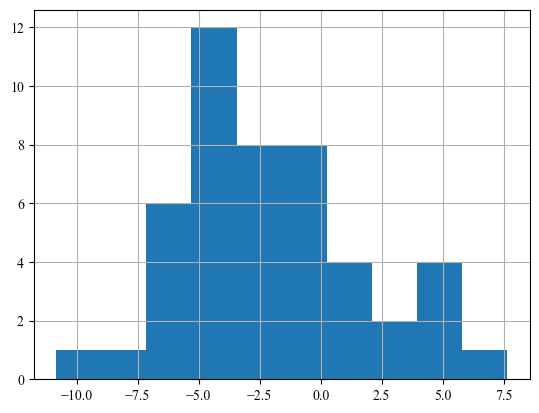

In [446]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

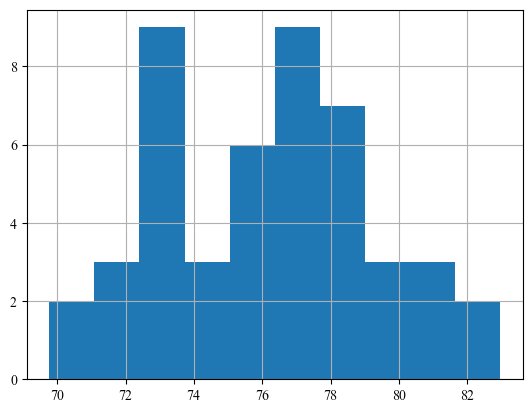

In [447]:
result_df.sort_values(ascending=False).hist()

In [448]:
(y_test-result_df).describe()

count    47.000000
mean     -1.944731
std       3.771946
min     -10.840438
25%      -4.522987
50%      -2.576448
75%      -0.007039
max       7.628454
dtype: float64

In [449]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,ShortPassing,Dribbling,FKAccuracy,LongPassing,Composure,Stamina,Strength,LongShots,Interceptions,Positioning,Vision,StandingTackle
ID,Name,FIFA,,,,,,,,,,,,,
246646,M. Caqueret,2020,52.0,74.0,66.0,52.0,74.0,69.0,66.0,56.0,56.0,60.0,57.0,72.0,59.0
246104,R. Gravenberch,2020,55.0,72.0,70.0,56.0,73.0,64.0,62.0,72.0,61.0,51.0,52.0,69.0,56.0
245367,X. Simons,2021,53.0,67.0,68.0,45.0,65.0,54.0,60.0,47.0,55.0,64.0,67.0,67.0,64.0
244675,Sancet,2020,63.0,71.0,74.0,36.0,64.0,67.0,58.0,46.0,62.0,62.0,66.0,71.0,57.0
241637,A. Tchouaméni,2020,49.0,72.0,71.0,45.0,70.0,70.0,72.0,74.0,48.0,69.0,67.0,66.0,71.0
245155,M. Kudus,2020,61.0,68.0,75.0,38.0,65.0,72.0,72.0,67.0,55.0,49.0,65.0,65.0,49.0
247328,Unai Vencedor,2020,52.0,64.0,63.0,76.0,67.0,69.0,63.0,64.0,63.0,52.0,45.0,64.0,63.0


In [450]:
y_test[outlier]

ID      Name            FIFA
246646  M. Caqueret     2020    79.0
246104  R. Gravenberch  2020    79.0
245367  X. Simons       2021    79.0
244675  Sancet          2020    81.0
241637  A. Tchouaméni   2020    84.0
245155  M. Kudus        2020    79.0
247328  Unai Vencedor   2020    77.0
Name: target, dtype: float64

In [451]:
result_df[outlier]

ID      Name            FIFA
246646  M. Caqueret     2020    75.641091
246104  R. Gravenberch  2020    74.997769
245367  X. Simons       2021    74.976399
244675  Sancet          2020    76.072114
241637  A. Tchouaméni   2020    76.371546
245155  M. Kudus        2020    73.440146
247328  Unai Vencedor   2020    73.375526
dtype: float64

In [452]:
(y_test/result_df).describe()

count    47.000000
mean      0.974410
std       0.050413
min       0.846974
25%       0.941786
50%       0.967211
75%       0.999954
max       1.099886
dtype: float64

In [453]:
(y_test/result_df).describe()

count    47.000000
mean      0.974410
std       0.050413
min       0.846974
25%       0.941786
50%       0.967211
75%       0.999954
max       1.099886
dtype: float64

In [454]:
np.corrcoef(y_test,result_df)

array([[1.       , 0.6477131],
       [0.6477131, 1.       ]])

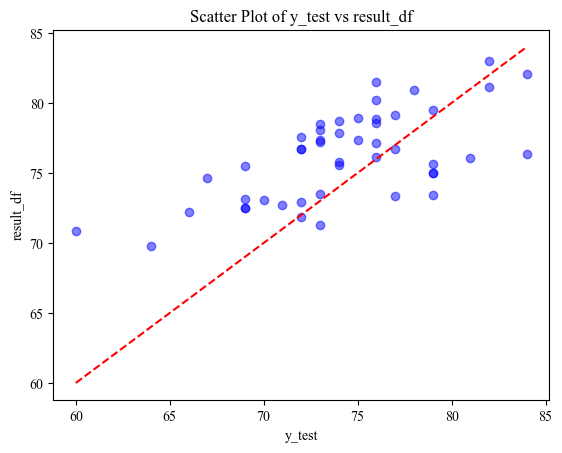

In [455]:
import matplotlib.pyplot as plt
plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [456]:
result_df = result_df.sort_values(ascending=False)

In [457]:
result_df.head(50)

ID      Name              FIFA
235569  T. Ndombele       2020    82.963819
247851  Bruno Guimarães   2021    82.088695
234060  Y. Herrera        2021    81.461542
248243  E. Camavinga      2021    81.144481
253109  J. Veerman        2021    80.890584
237629  A. Maier          2021    80.186878
236496  M. Guendouzi      2020    79.486446
244374  M. Shaparenko     2020    79.127795
244788  P. Bucha          2021    78.948020
234078  O. Mangala        2020    78.847069
237161  S. Longstaff      2020    78.723674
253157  H. Boudaoui       2021    78.576448
231445  J. Dasilva        2021    78.504382
243001  A. Cicâldău       2021    78.064751
241928  A. Sambi Lokonga  2021    77.871839
234795  A. Bernede        2020    77.550720
251217  Jean Lucas        2020    77.381359
234111  D. Turnbull       2021    77.335480
241856  Manu Morlanes     2020    77.232284
242816  Riqui Puig        2020    77.108474
244280  A. Fein           2020    76.735353
241607  T. Belmonte       2020    76.710495
2

In [458]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name             FIFA
235569  T. Ndombele      2020    82.963819
247851  Bruno Guimarães  2021    82.088695
248243  E. Camavinga     2021    81.144481
dtype: float64

In [459]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

2


ID      Name           FIFA
241637  A. Tchouaméni  2020    76.371546
244675  Sancet         2020    76.072114
dtype: float64

In [460]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

3


ID      Name        FIFA
234060  Y. Herrera  2021    81.461542
253109  J. Veerman  2021    80.890584
237629  A. Maier    2021    80.186878
dtype: float64

In [461]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

39


ID      Name              FIFA
246646  M. Caqueret       2020    75.641091
252541  J. Chotard        2021    75.764105
228946  M. Svanberg       2020    76.133381
236015  M. Gibbs-White    2020    76.702821
241607  T. Belmonte       2020    76.710495
244280  A. Fein           2020    76.735353
242816  Riqui Puig        2020    77.108474
241856  Manu Morlanes     2020    77.232284
234111  D. Turnbull       2021    77.335480
251217  Jean Lucas        2020    77.381359
234795  A. Bernede        2020    77.550720
241928  A. Sambi Lokonga  2021    77.871839
243001  A. Cicâldău       2021    78.064751
231445  J. Dasilva        2021    78.504382
253157  H. Boudaoui       2021    78.576448
237161  S. Longstaff      2020    78.723674
234078  O. Mangala        2020    78.847069
244788  P. Bucha          2021    78.948020
244374  M. Shaparenko     2020    79.127795
236496  M. Guendouzi      2020    79.486446
dtype: float64

In [462]:
from sklearn.metrics import  classification_report
print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.94      0.59      0.73        27
        True       0.63      0.95      0.76        20

    accuracy                           0.74        47
   macro avg       0.79      0.77      0.74        47
weighted avg       0.81      0.74      0.74        47

